<a href="https://colab.research.google.com/github/Ebadi-Fereshteh/Deep-Learning/blob/main/c%2050_pix2pix/%20cityscapes_pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pathlib
import time
import datetime
from IPython import display
from tqdm import tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/datasets/cityscapes/'
sample_image = tf.io.read_file(str(PATH)+'train/1.jpg')
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)
w= sample_image.shape[1]
print(w/2)
print(w//2)

(256, 512, 3)
256.0
256


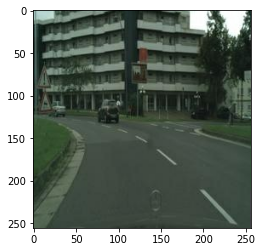

In [ ]:
plt.figure()
plt.imshow(sample_image[:,:256,:])

In [ ]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image= tf.io.read_file(image_file)
  image= tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building cityscapes image
  # - one with an architecture label image 

  w = tf.shape(image)[1]
  w = w//2
  segment_image = sample_image[:,w:,:]
  real_image = sample_image[:,:w,:]

  return segment_image,real_image


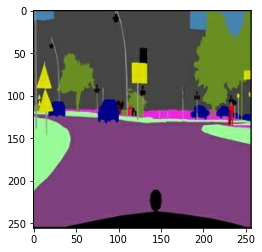

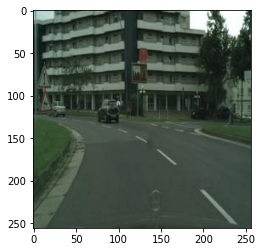

In [ ]:
inp, re = load(str(PATH) +'train/100.jpg')
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(tf.cast(inp, tf.float32) / 255.0)
plt.figure()
plt.imshow(tf.cast(re, tf.float32) / 255.0)

As described in the pix2pix paper, you need to apply random jittering and mirroring to preprocess the training set.

Define several functions that:

Resize each 256 x 256 image to a larger height and width—286 x 286.
Randomly crop it back to 256 x 256.
Randomly flip the image horizontally i.e. left to right (random mirroring).
Normalize the images to the [-1, 1] range.

In [ ]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def resize(segment_image, real_image, height, width):
  segment_image = tf.image.resize(segment_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return segment_image, real_image

In [ ]:
def random_crop(segment_image, real_image):
  stacked_image = tf.stack([segment_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [ ]:
# Normalizing the images to [-1, 1]
def normalize(segment_image, real_image):
  segment_image = (tf.cast(segment_image, tf.float32) / 127.5) - 1
  real_image = (tf.cast(real_image, tf.float32) / 127.5) - 1

  return segment_image, real_image

In [ ]:
@tf.function()
def random_jitter(segment_image, real_image):
  # Resizing to 286x286
  segment_image, real_image = resize(segment_image, real_image, 286, 286)

  # Random cropping back to 256x256
  segment_image, real_image = random_crop(segment_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    segment_image = tf.image.flip_left_right(segment_image)
    real_image = tf.image.flip_left_right(real_image)

  return segment_image, real_image

You can inspect some of the preprocessed output:

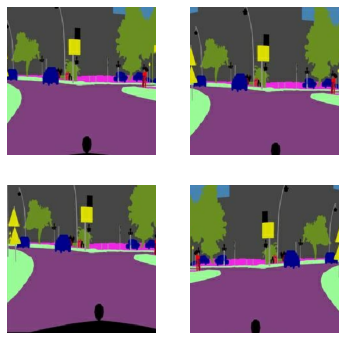

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255)
  plt.axis('off')
plt.show()

Having checked that the loading and preprocessing works, let's define a couple of helper functions that load and preprocess the training and test sets:

In [ ]:
def load_image_train(image_file):
  segment_image, real_image = load(image_file)
  segment_image, real_image = random_jitter(segment_image, real_image)
  segment_image, real_image = normalize(segment_image, real_image)

  return segment_image, real_image

In [ ]:
def load_image_test(image_file):
  segment_image, real_image = load(image_file)
  segment_image, real_image = resize(segment_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  segment_image, real_image = normalize(segment_image, real_image)

  return segment_image, real_image

## Build an input pipeline with tf.data

In [ ]:
train_dataset = tf.data.Dataset.list_files(str(PATH) + 'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH) + 'test/*.jpg')
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH) + 'val/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the generator
The generator of your pix2pix cGAN is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). (You can find out more about it in the Image segmentation tutorial and on the U-Net project website.)

Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
There are skip connections between the encoder and decoder (as in the U-Net).

Define the downsampler (encoder):

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4)
inp = tf.cast(inp, dtype=tf.float32)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


Define the upsampler (decoder):

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


Define the generator with the downsampler and the upsampler:

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture:

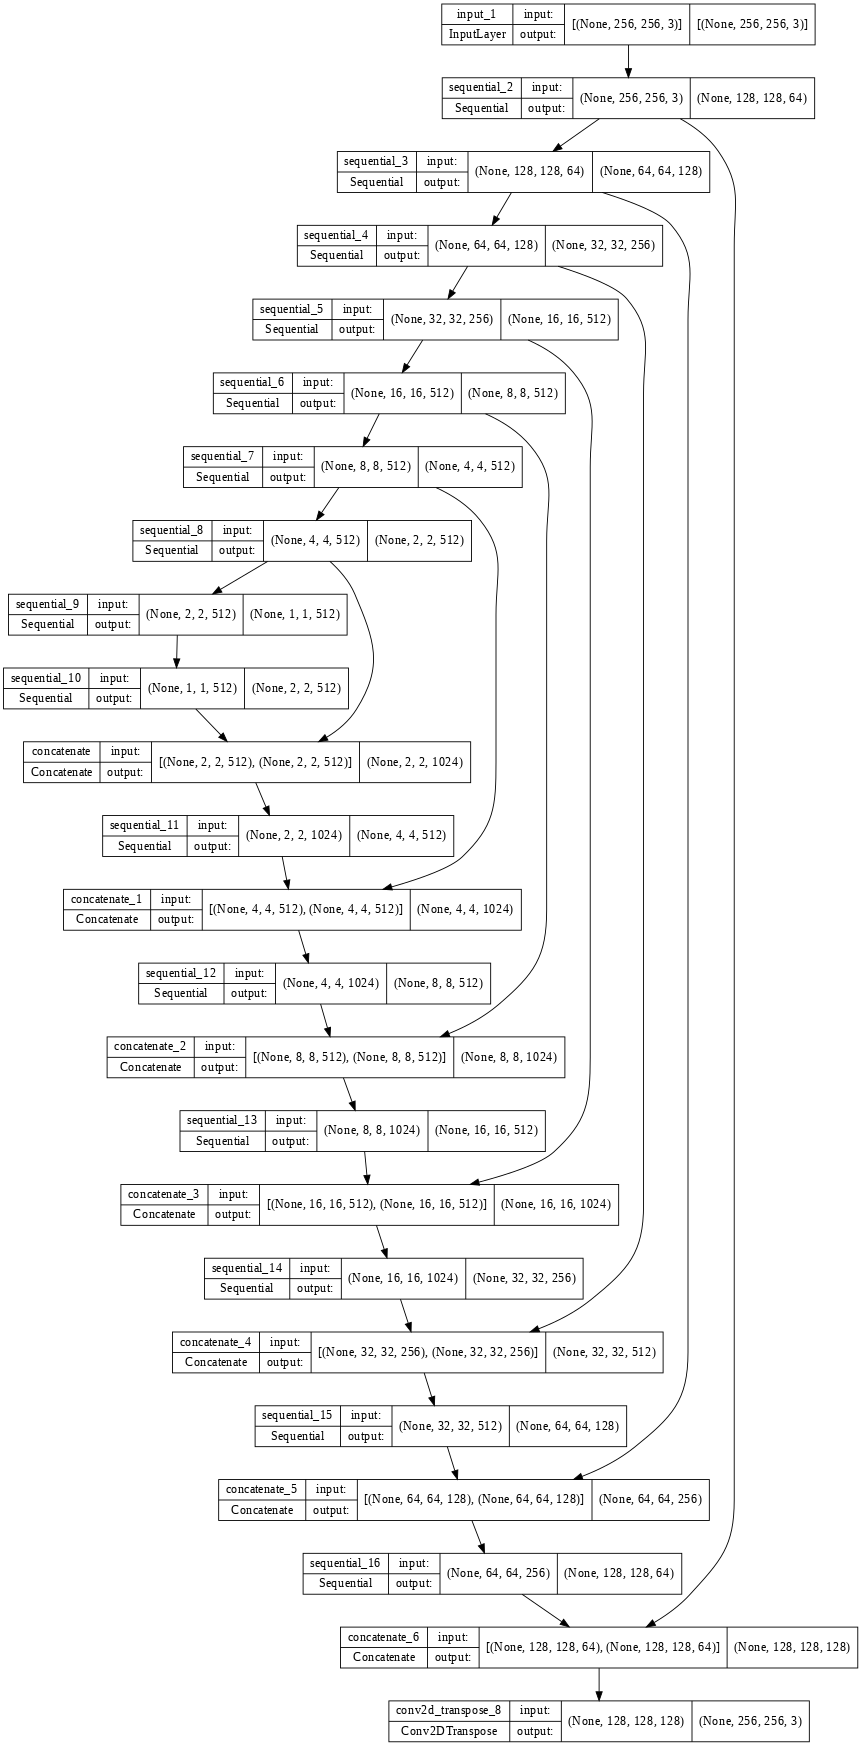

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Test the generator:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


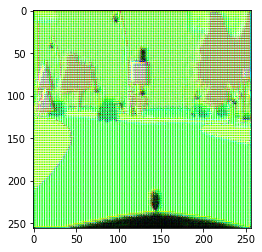

In [ ]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

Define the generator loss
GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the pix2pix paper.

The generator loss is a sigmoid cross-entropy loss of the generated images and an array of ones.
The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
This allows the generated image to become structurally similar to the target image.
The formula to calculate the total generator loss is gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the paper.

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

Build the discriminator
The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image patch is real or not real, as described in the pix2pix paper.

Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
The shape of the output after the last layer is (batch_size, 30, 30, 1).
Each 30 x 30 image patch of the output classifies a 70 x 70 portion of the input image.
The discriminator receives 2 inputs:
The input image and the target image, which it should classify as real.
The input image and the generated image (the output of the generator), which it should classify as fake.
Use tf.concat([inp, tar], axis=-1) to concatenate these 2 inputs together.

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

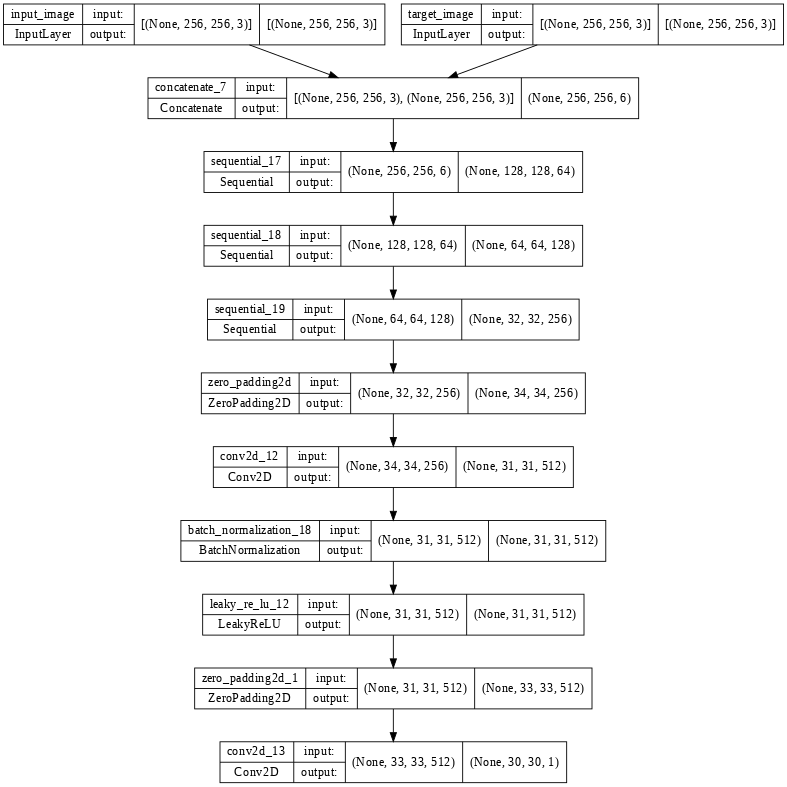

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Test the discriminator:

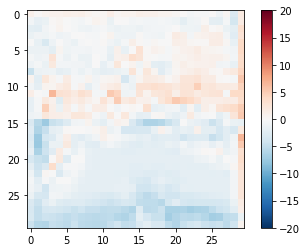

In [ ]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

Define the discriminator loss
The discriminator_loss function takes 2 inputs: real images and generated images.
real_loss is a sigmoid cross-entropy loss of the real images and an array of ones(since these are the real images).
generated_loss is a sigmoid cross-entropy loss of the generated images and an array of zeros (since these are the fake images).
The total_loss is the sum of real_loss and generated_loss.

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

Define the optimizers and a checkpoint-saver

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/models/cityscapes/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images
Write a function to plot some images during training.

Pass images from the test set to the generator.
The generator will then translate the input image into the output.
The last step is to plot the predictions and voila!

Note: The training=True is intentional here since you want the batch statistics, while running the model on the test dataset. If you use training=False, you get the accumulated statistics learned from the training dataset (which you don't want).

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Test the function:

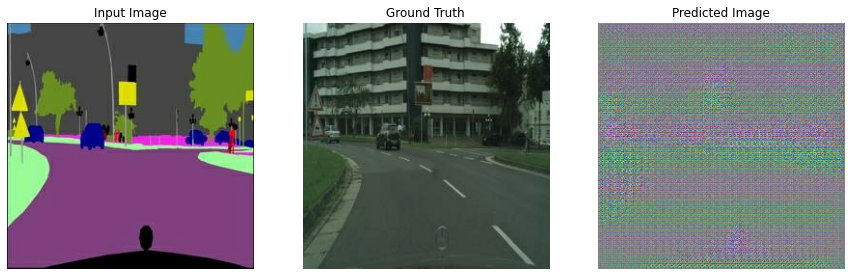

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training
For each example input generates an output.
The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
Next, calculate the generator and the discriminator loss.
Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
Finally, log the losses to TensorBoard.

In [ ]:
log_dir="/content/drive/MyDrive/models/cityscapes/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

Iterates over the number of steps.
Every 10 steps print a dot (.).
Every 1k steps: clear the display and run generate_images to show the progress.
Every 5k steps: save a checkpoint.

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in tqdm(train_ds.repeat().take(steps).enumerate()):
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

To launch the viewer paste the following into a code-cell:

In [ ]:
# !tensorboard dev upload --logdir {log_dir}
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

Finally, run the training loop:

Time taken for 1000 steps: 181.93 sec



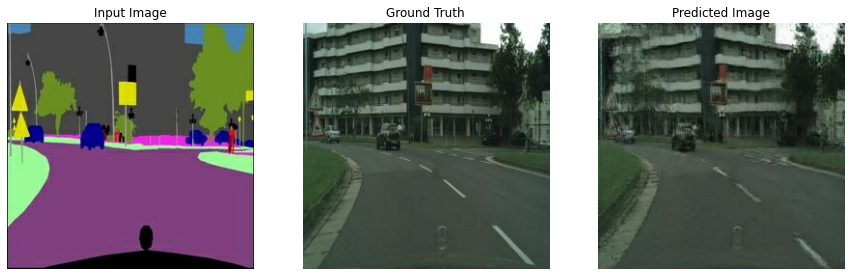

 98%|█████████▊| 39001/40000 [2:01:35<04:46,  3.49it/s]

Step: 39k


 98%|█████████▊| 39009/40000 [2:01:36<03:04,  5.39it/s]

.

 98%|█████████▊| 39019/40000 [2:01:38<02:59,  5.46it/s]

.

 98%|█████████▊| 39029/40000 [2:01:40<02:51,  5.65it/s]

.

 98%|█████████▊| 39039/40000 [2:01:42<02:54,  5.51it/s]

.

 98%|█████████▊| 39049/40000 [2:01:44<02:51,  5.55it/s]

.

 98%|█████████▊| 39059/40000 [2:01:45<02:47,  5.60it/s]

.

 98%|█████████▊| 39069/40000 [2:01:47<02:47,  5.56it/s]

.

 98%|█████████▊| 39079/40000 [2:01:49<02:47,  5.49it/s]

.

 98%|█████████▊| 39089/40000 [2:01:51<02:45,  5.52it/s]

.

 98%|█████████▊| 39099/40000 [2:01:53<02:42,  5.54it/s]

.

 98%|█████████▊| 39109/40000 [2:01:54<02:42,  5.47it/s]

.

 98%|█████████▊| 39119/40000 [2:01:56<02:42,  5.43it/s]

.

 98%|█████████▊| 39129/40000 [2:01:58<02:37,  5.54it/s]

.

 98%|█████████▊| 39139/40000 [2:02:00<02:33,  5.60it/s]

.

 98%|█████████▊| 39149/40000 [2:02:02<02:34,  5.51it/s]

.

 98%|█████████▊| 39159/40000 [2:02:04<02:32,  5.53it/s]

.

 98%|█████████▊| 39169/40000 [2:02:05<02:30,  5.54it/s]

.

 98%|█████████▊| 39179/40000 [2:02:07<02:28,  5.51it/s]

.

 98%|█████████▊| 39189/40000 [2:02:09<02:27,  5.51it/s]

.

 98%|█████████▊| 39199/40000 [2:02:11<02:23,  5.59it/s]

.

 98%|█████████▊| 39209/40000 [2:02:13<02:19,  5.65it/s]

.

 98%|█████████▊| 39219/40000 [2:02:14<02:20,  5.56it/s]

.

 98%|█████████▊| 39229/40000 [2:02:16<02:18,  5.57it/s]

.

 98%|█████████▊| 39239/40000 [2:02:18<02:16,  5.56it/s]

.

 98%|█████████▊| 39249/40000 [2:02:20<02:13,  5.61it/s]

.

 98%|█████████▊| 39259/40000 [2:02:22<02:13,  5.54it/s]

.

 98%|█████████▊| 39269/40000 [2:02:23<02:12,  5.52it/s]

.

 98%|█████████▊| 39279/40000 [2:02:25<02:09,  5.55it/s]

.

 98%|█████████▊| 39289/40000 [2:02:27<02:07,  5.56it/s]

.

 98%|█████████▊| 39299/40000 [2:02:29<02:05,  5.61it/s]

.

 98%|█████████▊| 39309/40000 [2:02:31<02:04,  5.56it/s]

.

 98%|█████████▊| 39319/40000 [2:02:32<02:01,  5.60it/s]

.

 98%|█████████▊| 39329/40000 [2:02:34<02:01,  5.54it/s]

.

 98%|█████████▊| 39339/40000 [2:02:36<01:59,  5.53it/s]

.

 98%|█████████▊| 39349/40000 [2:02:38<01:56,  5.57it/s]

.

 98%|█████████▊| 39359/40000 [2:02:40<01:55,  5.56it/s]

.

 98%|█████████▊| 39369/40000 [2:02:41<01:53,  5.55it/s]

.

 98%|█████████▊| 39379/40000 [2:02:43<01:50,  5.61it/s]

.

 98%|█████████▊| 39389/40000 [2:02:45<01:51,  5.50it/s]

.

 98%|█████████▊| 39399/40000 [2:02:47<01:48,  5.52it/s]

.

 99%|█████████▊| 39409/40000 [2:02:49<01:45,  5.58it/s]

.

 99%|█████████▊| 39419/40000 [2:02:50<01:44,  5.58it/s]

.

 99%|█████████▊| 39429/40000 [2:02:52<01:40,  5.69it/s]

.

 99%|█████████▊| 39439/40000 [2:02:54<01:40,  5.60it/s]

.

 99%|█████████▊| 39449/40000 [2:02:56<01:39,  5.56it/s]

.

 99%|█████████▊| 39459/40000 [2:02:58<01:35,  5.68it/s]

.

 99%|█████████▊| 39469/40000 [2:02:59<01:34,  5.64it/s]

.

 99%|█████████▊| 39479/40000 [2:03:01<01:33,  5.57it/s]

.

 99%|█████████▊| 39489/40000 [2:03:03<01:33,  5.49it/s]

.

 99%|█████████▊| 39499/40000 [2:03:05<01:28,  5.65it/s]

.

 99%|█████████▉| 39509/40000 [2:03:07<01:27,  5.59it/s]

.

 99%|█████████▉| 39519/40000 [2:03:08<01:25,  5.65it/s]

.

 99%|█████████▉| 39529/40000 [2:03:10<01:24,  5.57it/s]

.

 99%|█████████▉| 39539/40000 [2:03:12<01:21,  5.64it/s]

.

 99%|█████████▉| 39549/40000 [2:03:14<01:21,  5.53it/s]

.

 99%|█████████▉| 39559/40000 [2:03:16<01:19,  5.56it/s]

.

 99%|█████████▉| 39569/40000 [2:03:17<01:16,  5.61it/s]

.

 99%|█████████▉| 39579/40000 [2:03:19<01:16,  5.49it/s]

.

 99%|█████████▉| 39589/40000 [2:03:21<01:14,  5.49it/s]

.

 99%|█████████▉| 39599/40000 [2:03:23<01:12,  5.51it/s]

.

 99%|█████████▉| 39609/40000 [2:03:25<01:10,  5.56it/s]

.

 99%|█████████▉| 39619/40000 [2:03:26<01:07,  5.68it/s]

.

 99%|█████████▉| 39629/40000 [2:03:28<01:06,  5.59it/s]

.

 99%|█████████▉| 39639/40000 [2:03:30<01:04,  5.58it/s]

.

 99%|█████████▉| 39649/40000 [2:03:32<01:03,  5.56it/s]

.

 99%|█████████▉| 39659/40000 [2:03:34<01:00,  5.59it/s]

.

 99%|█████████▉| 39669/40000 [2:03:35<00:58,  5.62it/s]

.

 99%|█████████▉| 39679/40000 [2:03:37<00:57,  5.58it/s]

.

 99%|█████████▉| 39689/40000 [2:03:39<00:56,  5.55it/s]

.

 99%|█████████▉| 39699/40000 [2:03:41<00:54,  5.57it/s]

.

 99%|█████████▉| 39709/40000 [2:03:43<00:52,  5.57it/s]

.

 99%|█████████▉| 39719/40000 [2:03:44<00:50,  5.54it/s]

.

 99%|█████████▉| 39729/40000 [2:03:46<00:49,  5.52it/s]

.

 99%|█████████▉| 39739/40000 [2:03:48<00:47,  5.50it/s]

.

 99%|█████████▉| 39749/40000 [2:03:50<00:45,  5.54it/s]

.

 99%|█████████▉| 39759/40000 [2:03:52<00:43,  5.51it/s]

.

 99%|█████████▉| 39769/40000 [2:03:53<00:41,  5.61it/s]

.

 99%|█████████▉| 39779/40000 [2:03:55<00:39,  5.54it/s]

.

 99%|█████████▉| 39789/40000 [2:03:57<00:37,  5.60it/s]

.

 99%|█████████▉| 39799/40000 [2:03:59<00:35,  5.60it/s]

.

100%|█████████▉| 39809/40000 [2:04:01<00:33,  5.70it/s]

.

100%|█████████▉| 39819/40000 [2:04:02<00:32,  5.49it/s]

.

100%|█████████▉| 39829/40000 [2:04:04<00:31,  5.46it/s]

.

100%|█████████▉| 39839/40000 [2:04:06<00:29,  5.52it/s]

.

100%|█████████▉| 39849/40000 [2:04:08<00:26,  5.61it/s]

.

100%|█████████▉| 39859/40000 [2:04:10<00:25,  5.56it/s]

.

100%|█████████▉| 39869/40000 [2:04:12<00:23,  5.50it/s]

.

100%|█████████▉| 39879/40000 [2:04:13<00:21,  5.58it/s]

.

100%|█████████▉| 39889/40000 [2:04:15<00:19,  5.60it/s]

.

100%|█████████▉| 39899/40000 [2:04:17<00:18,  5.57it/s]

.

100%|█████████▉| 39909/40000 [2:04:19<00:15,  5.72it/s]

.

100%|█████████▉| 39919/40000 [2:04:21<00:14,  5.56it/s]

.

100%|█████████▉| 39929/40000 [2:04:22<00:12,  5.56it/s]

.

100%|█████████▉| 39939/40000 [2:04:24<00:11,  5.53it/s]

.

100%|█████████▉| 39949/40000 [2:04:26<00:09,  5.45it/s]

.

100%|█████████▉| 39959/40000 [2:04:28<00:07,  5.55it/s]

.

100%|█████████▉| 39969/40000 [2:04:30<00:05,  5.57it/s]

.

100%|█████████▉| 39979/40000 [2:04:31<00:03,  5.60it/s]

.

100%|█████████▉| 39989/40000 [2:04:33<00:02,  5.48it/s]

.

100%|█████████▉| 39999/40000 [2:04:35<00:00,  5.61it/s]

.

100%|██████████| 40000/40000 [2:04:38<00:00,  5.35it/s]


In [ ]:
fit(train_dataset, test_dataset, steps=40000)

In [ ]:
generator.save("/content/drive/MyDrive/models/cityscapes/cityscapes_pix2pix.h5")
generator.save_weights('/content/drive/MyDrive/models/cityscapes/cityscapes_pix2pix_weights', save_format='HDF5')

In [ ]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)